In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

# global imports
import sys
import time
import pickle
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm
import numpy as np
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# local imports
import utils
from utils import cm_metrics

# general settings  
plt.style.use('seaborn-v0_8-whitegrid')
plt.rc('font', size=14)
plt.rc('legend', fontsize=14)
plt.rc('lines', linewidth=2)
plt.rc('axes', linewidth=2)
plt.rc('axes', edgecolor='k')
plt.rc('xtick.major', width=2)
plt.rc('xtick.major', size=6)
plt.rc('ytick.major', width=2)
plt.rc('ytick.major', size=6)
plt.rc('pdf', fonttype=42)
plt.rc('ps', fonttype=42)

In [2]:
%%time
### parameters
subset_string = 'subset1'
subset = utils.get_subset(subset_string)
print(subset)
# remove PR from states
states = sorted(list(set(utils.states)-{'PR'}))
nstates = len(states)
print('nstates', nstates)
# load data
X_train_s, X_test_s, y_train_s, y_test_s, X_train_t, X_test_t, y_train_t, y_test_t = utils.load_ACSPublicCoverage(subset, states)

['SCHL', 'MAR', 'AGEP', 'SEX', 'CIT', 'RAC1P']
nstates 50
AK AL AR AZ CA CO CT DE FL GA HI IA ID IL IN KS KY LA MA MD ME MI MN MO MS MT NC ND NE NH NJ NM NV NY OH OK OR PA RI SC SD TN TX UT VA VT WA WI WV WY CPU times: total: 1min 47s
Wall time: 1min 48s


In [3]:
# load distances (see calculate_distances.ipynb)
dists = pickle.load( open("results/distances.pkl", "rb" ) )
# restrict to subset and states
dists = { k:{att:d for att, d in v.items() if att in subset} for k, v in dists.items() if k[0] in states and k[1] in states and k[0] != k[1]}

In [4]:
# some exploration of distances
pos = {a:i for i, a in enumerate(subset)}
d_att = [v['d_att'] for k, d in dists.items() for a, v in d.items()]
d_y_cond = [v['d_y_cond'] for k, d in dists.items() for a, v in d.items()]
d_splits = [v['d_splits'] for k, d in dists.items() for a, v in d.items()]
atts = [pos[a] for k, d in dists.items() for a, v in d.items()]

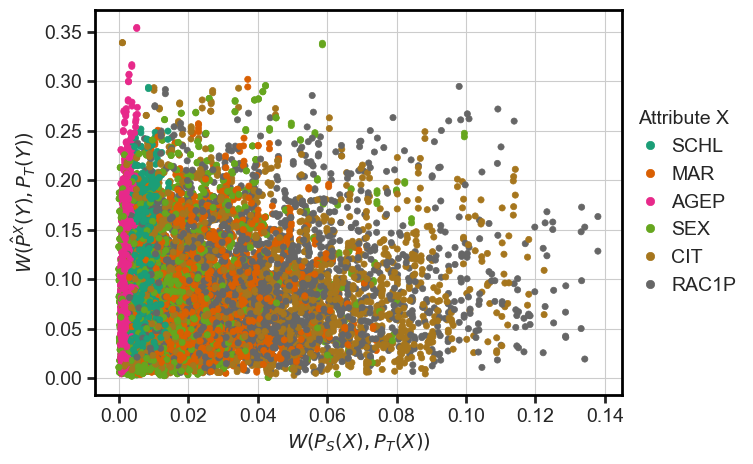

In [144]:
_, ax = plt.subplots(figsize=(4, 5))
scatter = ax.scatter(d_att, d_y_cond, c=atts, linewidths = .5, marker ="o", s=20, cmap="Dark2") # https://matplotlib.org/stable/tutorials/colors/colormaps.html
plt.xlabel('$W( P_S(X), P_T(X) )$')
plt.ylabel('$W( \hat{P}^X(Y), P_T(Y) )$')
pos = ax.get_position()
ax.set_position([pos.x0, pos.y0, pos.width * 1.7, pos.height])
ax.legend(scatter.legend_elements()[0], subset, title="Attribute X", loc='center right', handletextpad=0.1, bbox_to_anchor=(1.25, 0.5))
plt.savefig('fig1.png', bbox_inches='tight', dpi=400)
plt.show()

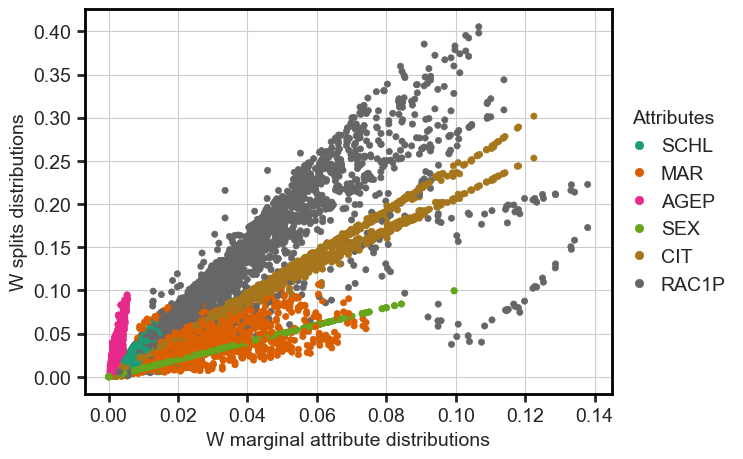

In [6]:
_, ax = plt.subplots(figsize=(4, 5))
scatter = ax.scatter(d_att, d_splits, c=atts, linewidths = .5, marker ="o", s=20, cmap="Dark2") # https://matplotlib.org/stable/tutorials/colors/colormaps.html
plt.xlabel('W marginal attribute distributions')
plt.ylabel('W splits distributions')
pos = ax.get_position()
ax.set_position([pos.x0, pos.y0, pos.width * 1.7, pos.height])
ax.legend(scatter.legend_elements()[0], subset, title="Attributes", loc='center right', handletextpad=0.1, bbox_to_anchor=(1.25, 0.5))
plt.show()

In [7]:
%%time
# compute dimensions of analysis
def sim(k, d, agg=np.mean, att=None):
    atts = dists[k]
    if att is None:
        return agg([v[d] for v in atts.values()])
    return atts[att][d]

res = dict()
for k in dists:
    sr, tg = k
    if sr == tg:
        continue
    res[(sr, tg)] = { 'avg_d_att':sim(k, 'd_att'),
                      'avg_d_y_cond':sim(k, 'd_y_cond'),
                      'avg_d_splits':sim(k, 'd_splits'),
                      'min_d_y_cond':sim(k, 'd_y_cond', np.min)
                    }
avg_d_att = [v['avg_d_att'] for v in res.values()]
avg_d_y_cond = [v['avg_d_y_cond'] for v in res.values()]
avg_d_splits = [v['avg_d_splits'] for v in res.values()]
min_d_y_cond = [v['min_d_y_cond'] for v in res.values()]

CPU times: total: 109 ms
Wall time: 111 ms


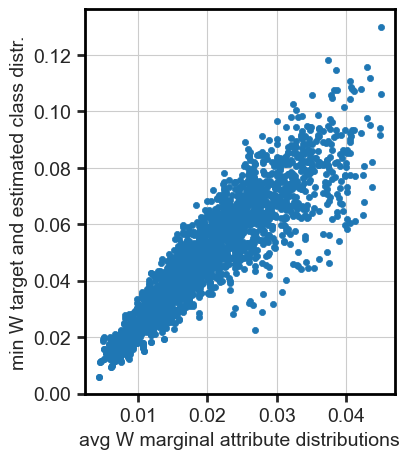

In [8]:
_, ax = plt.subplots(figsize=(4, 5))
scatter = ax.scatter(avg_d_att, avg_d_splits, linewidths = .5, marker ="o", s=20) # https://matplotlib.org/stable/tutorials/colors/colormaps.html
plt.xlabel('avg W marginal attribute distributions')
plt.ylabel('min W target and estimated class distr.')
plt.show()

In [ ]:
# run test on model training

In [118]:
# parameters
max_depth = 8
maxdepth_td = 8
min_pct = 0.05
source = 'AL'
target = 'OR'
att_td = 'MAR'
t_o = None #'true_positive_rate_parity' #'demographic_parity'
# distances
print(subset, dists[(source, target)])
# derived parameters
size = len(X_train_s[source])
min_cases = int(size*min_pct)

['SCHL', 'MAR', 'AGEP', 'SEX', 'CIT', 'RAC1P'] {'AGEP': {'d_att': 0.0006396950840207692, 'd_y_cond': 0.06311084562224045, 'd_splits': 0.010515974295389, 'd_y_cond_est': 0.07759983660222014, 'len_s_train': 14284, 'len_t_train': 11004, 'len_t_test': 3669}, 'SCHL': {'d_att': 0.00821261825380029, 'd_y_cond': 0.0945665713757643, 'd_splits': 0.02383753189558601, 'd_y_cond_est': 0.09430977740840138, 'len_s_train': 14284, 'len_t_train': 11004, 'len_t_test': 3669}, 'MAR': {'d_att': 0.011455949777586544, 'd_y_cond': 0.0603242820532249, 'd_splits': 0.014357808235140258, 'd_y_cond_est': 0.08149840055558766, 'len_s_train': 14284, 'len_t_train': 11004, 'len_t_test': 3669}, 'SEX': {'d_att': 0.01000262525141693, 'd_y_cond': 0.07598000753010789, 'd_splits': 0.01000262525141693, 'd_y_cond_est': 0.07598000753010795, 'len_s_train': 14284, 'len_t_train': 11004, 'len_t_test': 3669}, 'CIT': {'d_att': 0.02943382213499208, 'd_y_cond': 0.09012550000573281, 'd_splits': 0.06844024673724143, 'd_y_cond_est': 0.0880

In [115]:
[(c, dists[(source, target)][c]['d_y_cond']) for c in X_train_s[source].columns]

[('SCHL', 0.0945665713757643),
 ('MAR', 0.0603242820532249),
 ('AGEP', 0.06311084562224045),
 ('SEX', 0.07598000753010789),
 ('CIT', 0.09012550000573281),
 ('RAC1P', 0.11982475732494548)]

In [116]:
%%time
# train on target, test on target
clf_t, cm_t, cm_unprotected_t, cm_protected_t = utils.run_test(X_train_s[target], y_train_s[target], X_test_t[target], 
    y_test_t[target], X_td=None, max_depth=max_depth, min_cases=int(len(X_train_s[target])*min_pct), t_o=t_o)

CPU times: total: 1.05 s
Wall time: 1.04 s


In [117]:
print('cm', cm_t)
print('cm_unprotected', cm_unprotected_t)
print('cm_protected', cm_protected_t)
print('acc', cm_metrics(cm_t)[0])
print('dp', cm_metrics(cm_unprotected_t)[4] - cm_metrics(cm_protected_t)[4])
print('eop', cm_metrics(cm_unprotected_t)[1] - cm_metrics(cm_protected_t)[1])

cm [[2057  351]
 [ 760  501]]
cm_unprotected [[820 169]
 [336 250]]
cm_protected [[1237  182]
 [ 424  251]]
acc 0.6971926955573726
dp 0.05925046618456359
eop 0.054769308557704455


In [142]:
%%time
# train on source, test on target
clf_s, cm_s, cm_unprotected_s, cm_protected_s = utils.run_test(X_train_s[source], y_train_s[source], X_test_t[target], 
    y_test_t[target], X_td=X_train_t[target], max_depth=max_depth, min_cases=int(len(X_train_s[source])*min_pct), 
                                                y_td=y_train_t[target], t_o=t_o, alpha=None)

CPU times: total: 1.36 s
Wall time: 1.36 s


In [143]:
print('cm', cm_s)
print('cm_unprotected', cm_unprotected_s)
print('cm_protected', cm_protected_s)
print('acc', cm_metrics(cm_s)[0])
print('dp', cm_metrics(cm_unprotected_s)[4] - cm_metrics(cm_protected_s)[4])
print('eop', cm_metrics(cm_unprotected_s)[1] - cm_metrics(cm_protected_s)[1])

cm [[2276  132]
 [1056  205]]
cm_unprotected [[934  55]
 [481 105]]
cm_protected [[1342   77]
 [ 575  100]]
acc 0.6762060506950123
dp 0.017060080956929097
eop 0.031032739223865513


In [135]:
%%time
# train on source, test on target, alpha=0
alpha = 0
clf_0, cm_0, cm_unprotected_0, cm_protected_0 = utils.run_test(X_train_s[source], y_train_s[source], X_test_t[target], 
    y_test_t[target], X_td=X_train_t[target], alpha=alpha, max_depth=max_depth, min_cases=min_cases, 
    y_td=y_train_t[target],att_td=att_td, t_o=t_o, maxdepth_td=maxdepth_td)

CPU times: total: 4.38 s
Wall time: 4.38 s


In [136]:
print('cm', cm_0)
print('cm_unprotected', cm_unprotected_0)
print('cm_protected', cm_protected_0)
print('acc', cm_metrics(cm_0)[0])
print('dp', cm_metrics(cm_unprotected_0)[4] - cm_metrics(cm_protected_0)[4])
print('eop', cm_metrics(cm_unprotected_0)[1] - cm_metrics(cm_protected_0)[1])

cm [[2304  104]
 [1083  178]]
cm_unprotected [[944  45]
 [495  91]]
cm_protected [[1360   59]
 [ 588   87]]
acc 0.6764786045243936
dp 0.016626188202119446
eop 0.02640121350018962


In [137]:
clf_t.tree

{'type': 'split',
 'gain': 0.021032382642826253,
 'split_col': 'MAR',
 'cutoff': 3.0,
 'tot': 11004,
 'dist': array([0.64930934, 0.35069066]),
 'left': {'type': 'split',
  'gain': 0.02162465177084877,
  'split_col': 'AGEP',
  'cutoff': 53.0,
  'tot': 1181,
  'dist': array([0.4081287, 0.5918713]),
  'left': {'type': 'leaf',
   'tot': 610,
   'dist': array([0.49016393, 0.50983607])},
  'right': {'type': 'leaf',
   'tot': 571,
   'dist': array([0.32049037, 0.67950963])}},
 'right': {'type': 'split',
  'gain': 0.012607475267715884,
  'split_col': 'MAR',
  'cutoff': 1.0,
  'tot': 9823,
  'dist': array([0.67830602, 0.32169398]),
  'left': {'type': 'split',
   'gain': 0.016373729205872767,
   'split_col': 'SCHL',
   'cutoff': 21.0,
   'tot': 4167,
   'dist': array([0.74970002, 0.25029998]),
   'left': {'type': 'leaf',
    'tot': 773,
    'dist': array([0.87839586, 0.12160414])},
   'right': {'type': 'split',
    'gain': 0.009122801548116954,
    'split_col': 'SEX',
    'cutoff': 1.0,
    'tot

In [138]:
clf_s.w_dist(), clf_s.tree

(0.11044574847988227,
 {'type': 'split',
  'gain': 0.016543420941708575,
  'split_col': 'RAC1P',
  'cutoff': 2.0,
  'tot': 14284,
  'dist': array([0.72556707, 0.27443293]),
  'left': {'type': 'split',
   'gain': 0.017551274185939547,
   'split_col': 'AGEP',
   'cutoff': 54.0,
   'tot': 4054,
   'dist': array([0.61618155, 0.38381845]),
   'left': {'type': 'split',
    'gain': 0.011780225452817539,
    'split_col': 'AGEP',
    'cutoff': 20.0,
    'tot': 3160,
    'dist': array([0.65696203, 0.34303797]),
    'left': {'type': 'leaf',
     'tot': 737,
     'dist': array([0.54545455, 0.45454545])},
    'right': {'type': 'split',
     'gain': 0.007918206166596553,
     'split_col': 'SEX',
     'cutoff': 1.0,
     'tot': 2423,
     'dist': array([0.69087908, 0.30912092]),
     'left': {'type': 'leaf',
      'tot': 1153,
      'dist': array([0.7415438, 0.2584562])},
     'right': {'type': 'leaf',
      'tot': 1270,
      'dist': array([0.64488189, 0.35511811])}}},
   'right': {'type': 'leaf',
 

In [139]:
clf_0.w_dist(), clf_0.tree

(0.11304092169912443,
 {'type': 'split',
  'gain': 0.0598708535859489,
  'split_col': 'RAC1P',
  'cutoff': 2.0,
  'tot': 14284,
  'dist': array([0.73080774, 0.26919226]),
  'left': {'type': 'split',
   'gain': 0.023039778935278643,
   'split_col': 'AGEP',
   'cutoff': 53.0,
   'tot': 4054,
   'dist': array([0.63036668, 0.36963332]),
   'left': {'type': 'split',
    'gain': 0.013052541809176588,
    'split_col': 'AGEP',
    'cutoff': 20.0,
    'tot': 3093,
    'dist': array([0.67059539, 0.32940461]),
    'left': {'type': 'leaf',
     'tot': 737,
     'dist': array([0.54293629, 0.45706371])},
    'right': {'type': 'split',
     'gain': 0.019527053471736833,
     'split_col': 'SEX',
     'cutoff': 1.0,
     'tot': 2356,
     'dist': array([0.70381489, 0.29618511]),
     'left': {'type': 'leaf',
      'tot': 1129,
      'dist': array([0.74340755, 0.25659245])},
     'right': {'type': 'leaf',
      'tot': 1227,
      'dist': array([0.67293623, 0.32706377])}}},
   'right': {'type': 'leaf',
 

In [ ]:
# sample input file

import folktables as ft
import pandas as pd

task_method=ft.ACSPublicCoverage
source_data = utils.load_folktables_data(['NY'], '2017', '1-Year', 'person') 
features_s, labels_s, group_s = utils.load_task(source_data, task_method)
X = pd.DataFrame(features_s, columns=task_method.features)
X['y'] = labels_s
x

In [ ]:
# synthetic data experiment: old stuff

import numpy as np
import pandas as pd

def get_y_given_x(x, opt=0):
    y = []
    for v in x:
        if v==1:
            r = np.random.choice(np.arange(0, 2), p=[0.3+opt, 0.7-opt])
        elif v==2:
            r = np.random.choice(np.arange(0, 2), p=[0.4, 0.6])
        elif v==3:
            r = np.random.choice(np.arange(0, 2), p=[0.2, 0.8])
        elif v==4:
            r = np.random.choice(np.arange(0, 2), p=[0.1, 0.9])
        elif v==5:
            r = np.random.choice(np.arange(0, 2), p=[0.8, 0.2])
        else:
            r = np.random.choice(np.arange(0, 2), p=[0.9, 0.1])
        y.append(r)
    return np.array(y)
n = 20000
x = np.random.choice(np.arange(1, 7), size=n, p=[0.1, 0.05, 0.05, 0.2, 0.4, 0.2])
y = get_y_given_x(x)
df1 = pd.DataFrame({"x":x, "y":y})
x = np.random.choice(np.arange(1, 7), size=n, p=[0.5, 0.1, 0.1, 0.1, 0.1, 0.1])
y = get_y_given_x(x, opt=0.0)
df2 = pd.DataFrame({"x":x, "y":y})

In [ ]:
X_train_1, X_test_1, y_train_1, y_test_1 = utils.split_data(df1[["x"]], df1["y"])
X_train_2, X_test_2, y_train_2, y_test_2 = utils.split_data(df2[["x"]], df2["y"])

In [ ]:
def checkatt2(att):
    xs = X_train_1[att]
    xt = X_train_2[att]
    values = sorted(xs.unique())
    ratios = []
    for value in values:
        cond = (xs==value) & (y_train_1==1)
        ps = sum(cond)/sum(xs==value)
        cond = (xt==value) & (y_train_2==1)
        pt = sum(cond)/sum(xt==value)
        ratio = ps/pt
        ratios.append(ratio)
        print(value, ps, pt, ratio)
    print(np.mean(ratios), np.std(ratios))

checkatt2('x')

In [ ]:
from decision_tree_classifier import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
from utils import cm_metrics

clf1 = DecisionTreeClassifier(max_depth)
clf1.fit(X_train_1, y_train_1, ["x"], 1)
y_pred = clf1.predict(X_test_2)
cm1 = confusion_matrix(y_test_2, y_pred)
print(cm_metrics(cm1))
clf1.tree

In [ ]:
clf2 = DecisionTreeClassifier(max_depth)
clf2.fit(X_train_1, y_train_1, ["x"], 0, X_train_2, y_train_2)
y_pred = clf2.predict(X_test_2)
cm2 = confusion_matrix(y_test_2, y_pred)
print(cm_metrics(cm2))
clf2.tree

In [ ]:
clf3 = DecisionTreeClassifier(max_depth)
clf3.fit(X_train_2, y_train_2, ["x"], 1)
y_pred = clf3.predict(X_test_2)
cm3 = confusion_matrix(y_test_2, y_pred)
print(cm_metrics(cm3))
clf3.tree